# Json file analysis
This json dump contains multi level nested structure, though not complex, let find out distinct nested keys and their parent

In [1]:
# First code snipets be all imports
# this is because jupyter kernel dies very often, so on restarts, all the imports need to be reloaded
import json, sys, os

In [25]:
# variables
distinct_elements = []
node_tree_list = []
distinct_flat_node_tree_list = []
flat_list = []

def get_last_elements(node):
  if (len(node.split(':')) > 1):
    return node.rsplit(':', 2)[-2]
  return ''

def keys(d, c = []):
  return [i for a, b in d.items() for i in ([c+[a]] if not isinstance(b, dict) else keys(b, c+[a]))]

def flatten_nested_list(lst):
  return [item for sublist in lst for item in sublist]

def item_in_this_list(item, lst):
  last_match = 0
  element = ''
  nodeLst = item.split(':')
  if len(nodeLst) == 1:
    return None
  for i, node in enumerate(nodeLst):
    if node in lst:
      last_match = i
      continue;
    return nodeLst[last_match] if last_match == 0 else ':'.join(nodeLst[0:last_match + 1])

def distinct_list_elements(lst):
  for node in lst:
    if node not in distinct_flat_node_tree_list:
        distinct_flat_node_tree_list.append(node)

with open("testEventData-1.txt") as json_file:
    for line in json_file:
        node = json.loads(line)
        node_tree = list(map(':'.join, keys(node)))
        node_tree_list.append(node_tree)
        nested_parents_only = list(set(filter(None, [get_last_elements(node) for node in node_tree])))
        distinct_elements.append(nested_parents_only)
flat_list = list(set(flatten_nested_list(distinct_elements)))
distinct_list_elements(flatten_nested_list(node_tree_list))
flat_list.sort()
print(flat_list)
# print([item_in_this_list(item, flat_list) for item in distinct_flat_node_tree_list])
final_distinct_node_tree = list(set(filter(None, [item_in_this_list(item, flat_list) for item in distinct_flat_node_tree_list])))
final_distinct_node_tree.sort()
print(final_distinct_node_tree)

      

['address', 'bsProperties', 'performance', 'properties', 'report', 'smartbrand', 'telephoneVerification', 'thestralFeatures']
['properties', 'properties:address', 'properties:address:telephoneVerification', 'properties:bsProperties', 'properties:performance', 'properties:report', 'properties:smartbrand', 'properties:thestralFeatures']


### Converting the file to valid JSON
The file is collection of json dictionaries, but not embedded in a json root node, lets do that

In [ ]:
json_events = {}
with open('testEventData-1.txt', 'r') as f:
    events = [json.loads(line) for line in f]
json_events['events'] = events
with open('testEventData-1.json', 'w', encoding='utf-8') as f:
    json.dump(json_events, f, ensure_ascii=False, indent=4)


### Tree view
Lets see how this JSON tree looks like

[('properties', 'performance'), ('properties', 'queryParameters'), ('properties', 'smartbrand'), ('properties', 'filterMethod'), ('address', 'telephoneVerification'), ('properties', 'bsProperties'), ('event', 'properties'), ('properties', 'report'), ('properties', 'thestralFeatures'), ('properties', 'address')]
strict digraph tree {
    properties -> performance;
    properties -> queryParameters;
    properties -> smartbrand;
    properties -> filterMethod;
    address -> telephoneVerification;
    properties -> bsProperties;
    event -> properties;
    properties -> report;
    properties -> thestralFeatures;
    properties -> address;
}


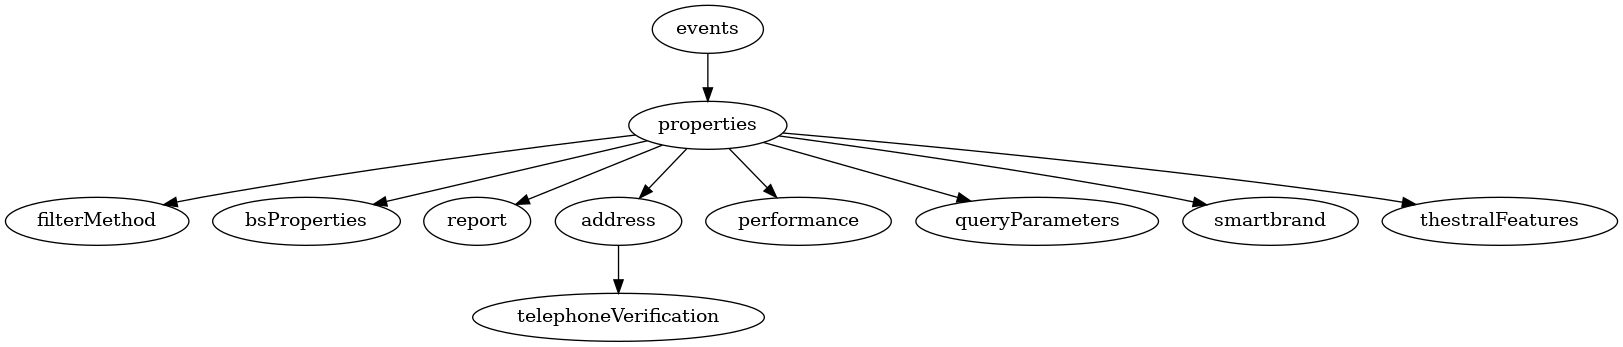

In [2]:
import json, os, graphviz
from graphviz import Source
from IPython.display import Image

# variables
edges = []

def removeDuplicates(lst):
    return [t for t in (set(tuple(i) for i in lst))]

def keys(d, root):
  for a, b in d.items():
      if isinstance(b, dict):
        edges.append((root, a))
        keys(b, a)
    
with open(os.path.join(os.getcwd(), './testEventData-1.json'), 'r') as f:
    events_json = json.load(f)

for item in events_json['events']:
    keys(item, 'event')
edges_deduped = removeDuplicates(edges)
print(edges_deduped)

# Dump edges in a grapgViz format
digraphStr = 'strict digraph tree {\n'
for row in edges_deduped:
    digraphStr = digraphStr + '    {0} -> {1};\n'.format(*row)
digraphStr = digraphStr + '}'
print(digraphStr)
graph_img_filePath = os.path.join(os.getcwd(), 'json_tree.gv')
with open('json_tree.gv', "w") as text_file:
    text_file.write(digraphStr)

Source.from_file('json_tree.gv', format='png')
Image(filename='json_tree.gv.png')